# Independent Feature EDA

Before performing any eda on the target (which will occur only after a train test split), I will look at the independent features held in the data set.  I do not want to look at the target, graduation rate, until after the split, so that I can prevent introducing bias into the model. 

First, I will look at the most current year data in the csv folder (2018-19).  

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
# Set absolute path to the root folder of the directory
full_path = os.getcwd()
home_folder = 'CPS_GradRate_Analysis'
root = full_path.split(home_folder)[0] + home_folder + '/'
sys.path.append(root)

# Cleaning functions are imported from the cleaning.py file in the src folder
from src.cleaning import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.api import ttest_ind

In [3]:
# Create 2018-2019 SchoolYear class
path_to_pr_1819 = root + 'data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1819.csv'
path_to_sp_1819 = root + 'data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1819.csv'

# Custom functions in src/cleaning.py

# sy_1819 will hold data about all of the schools to allow for eda on the entire student population
sy_1819 = import_and_merge_data(path_to_sp_1819, path_to_pr_1819)

# As shown below, the high school df will be cleaned to have a specific subset of records
sy_1819_hs = import_and_merge_data(path_to_sp_1819, path_to_pr_1819)
sy_1819_hs = convert_is_high_school_to_bool(sy_1819_hs)
sy_1819_hs = isolate_high_schools(sy_1819_hs)
sy_1819_hs = make_percent_low_income(sy_1819_hs)


In [4]:
# These will be used to create new features that describe change in school populations
path_to_pr_1718 = root + '/data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1718.csv'
path_to_sp_1718 = root + '/data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1718.csv'
sy_1718 = import_and_merge_data(path_to_sp_1718, path_to_pr_1718)

# As shown below, the high school df will be cleaned to have a specific subset of records
sy_1718_hs = import_and_merge_data(path_to_sp_1718, path_to_pr_1718)
sy_1718_hs = convert_is_high_school_to_bool(sy_1718_hs)
sy_1718_hs = isolate_high_schools(sy_1718_hs)
sy_1718_hs = make_percent_low_income(sy_1718_hs)



In [5]:
# These will be used to create new features that describe change in school populations
path_to_pr_1617 = root + '/data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1617.csv'
path_to_sp_1617 = root + '/data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1617.csv'
sy_1617 = import_and_merge_data(path_to_sp_1617, path_to_pr_1617)

# As shown below, the high school df will be cleaned to have a specific subset of records
sy_1617_hs = import_and_merge_data(path_to_sp_1617, path_to_pr_1617)
sy_1617_hs = convert_is_high_school_to_bool(sy_1617_hs)
sy_1617_hs = isolate_high_schools(sy_1617_hs)
sy_1617_hs = make_percent_low_income(sy_1617_hs)


# School Counts

In 2018-2019, there are 651 total schools in CPS and there are 176 high schools.

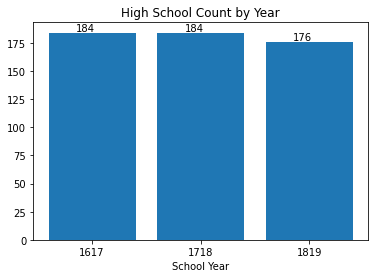

In [6]:
fig, ax = plt.subplots()
hs_counts = {'1617': len(sy_1617_hs.School_ID.unique()),
             '1718': len(sy_1718_hs.School_ID.unique()),
             '1819': len(sy_1819_hs.School_ID.unique())}

bars = ax.bar(list(hs_counts.keys()), list(hs_counts.values()))
ax.set_title('High School Count by Year')
ax.set_xlabel('School Year')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+ .25, yval + 1, yval)


## High School Counts by Network

CPS High Schools are organized into 4 Networks numbered 14 - 17.  There are also three 3 "other networks":
  - [ISP (Independent School Principals)](https://www.cps.edu/schools/networks/network-isp/)
  >> "Independent School Principals (ISP) is designed for the highest-performing principals within the district.ISP provides support to principals who can ensure continued strong performance with minimal oversight from the district, and who would benefit from additional independence to lead their schools." 
  - [Academy for Urban School Leadership (AUSL)](https://www.cps.edu/schools/networks/network-ausl/)
  >> "Founded in 2001 as the nation’s ﬁrst teacher residency program, Academy for Urban School Leadership (AUSL) grew by transforming underperforming schools in Chicago. The Academy for Urban School Leadership is a non-profit school management organization that leads one of the largest school networks in Chicago with 31 neighborhood Schools of Excellence."
  - [Charter, Contract, and Options Schools](https://www.cps.edu/schools/networks/network-charter-contract-options/)
  >> CPS charter and contract schools offer additional public elementary and high school choices for Chicago students. CPS Options schools are designed to be a unique learning model for students who are not engaged in a traditional high school and seek an alternative pathway to graduation that leads to college and career success.



The school count in the 4 numbered school districts are evenly distributed from between 16 and 18 schools each. The ISP district also falls in that range. Charter and Options networks have a larger number of schools. Contract and AUSL have only a handful of schools each.     

<ipython-input-7-0b048e6cdaaa>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45);


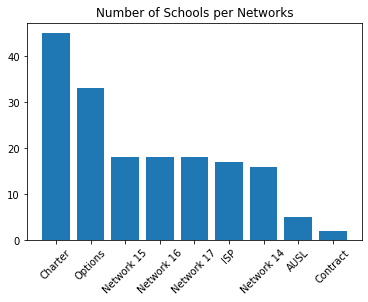

In [7]:
fig, ax = plt.subplots()

y = sy_1819_hs['Network'].value_counts().values
x = sy_1819_hs['Network'].value_counts().index

ax.bar(x,y)
ax.set_xticklabels(x, rotation=45);
ax.set_title('Number of Schools per Networks');

In [8]:
sy_1819_hs['Network'].value_counts()

Charter       45
Options       33
Network 15    18
Network 16    18
Network 17    18
ISP           17
Network 14    16
AUSL           5
Contract       2
Name: Network, dtype: int64

## Dropping Schools whose records in the 2018-19 year have no student count.

There are 2 schools in the data set that do not have student counts.  Englewood STEM HS didn't open until 2019, per their [website](https://englestem.enschool.org/apps/pages/index.jsp?uREC_ID=447546&type=d&pREC_ID=843929). YCCS is a Virtual High School, whose online records don't show student counts.  These are dropped in the current version of the project.

In [8]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']==0]

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

In [9]:
sy_1819_hs = drop_no_students(sy_1819_hs)
len(sy_1819_hs.School_ID.unique())

0 Student Count
2 schools
15     ENGLEWOOD STEM HS
582       YCCS - VIRTUAL
Name: Short_Name_sp, dtype: object
All 0 Student Count Schools Dropped


174

In [10]:
# These same schools also have no student count in 1718
sy_1718_hs[sy_1718_hs['School_ID'].isin([610592, 400142])]['Student_Count_Total']

604    0
633    0
Name: Student_Count_Total, dtype: int64

Although there are a large number of Options schools, these schools serve a small population, as shown in the plots below.

Text(0, 0.5, 'Total # of Students')

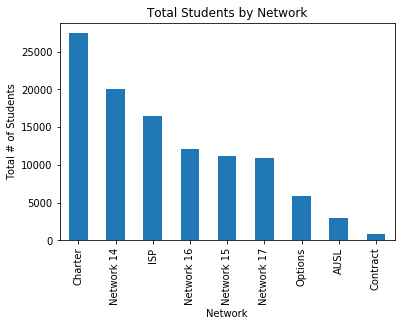

In [11]:
student_count_by_network = sy_1819_hs.groupby("Network").sum()['Student_Count_Total'].sort_values(ascending=False)

fig, ax = plt.subplots()

student_count_by_network.plot(kind='bar', ax = ax)
ax.set_title('Total Students by Network')
ax.set_ylabel('Total # of Students')

Network 14 serves the most students per school. 

Text(0, 0.5, 'Mean # of Students per Network')

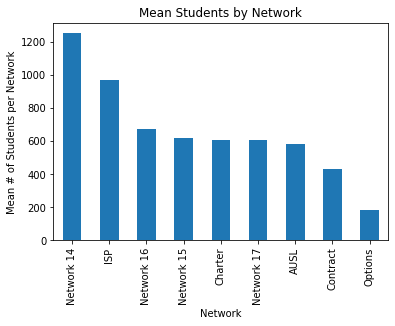

In [12]:
student_count_by_network = sy_1819_hs.groupby("Network").mean()['Student_Count_Total'].sort_values(ascending=False)

fig, ax = plt.subplots()

student_count_by_network.plot(kind='bar', ax = ax)
ax.set_title('Mean Students by Network')
ax.set_ylabel('Mean # of Students per Network')

# Graduation Rate

In [13]:
sy_1819_hs[['Graduation_Rate_School']].describe()

,Graduation_Rate_School
count,136.000000
mean,72.900000
std,22.721466
min,0.000000
25%,66.300000
50%,80.400000
75%,86.475000
max,98.300000


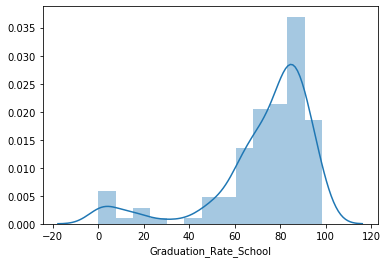

In [14]:
fig, ax = plt.subplots()
sns.distplot(sy_1819_hs['Graduation_Rate_School'].dropna(), ax=ax)

In [15]:
hs_1819_main_nws = isolate_main_networks(sy_1819_hs)

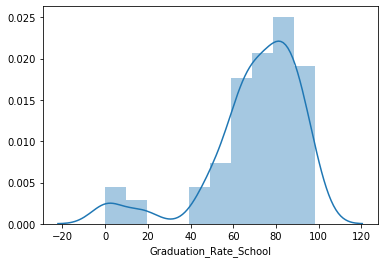

In [16]:
fig, ax = plt.subplots()
sns.distplot(hs_1819_main_nws['Graduation_Rate_School'].dropna(), ax=ax)

## Graduation Rate Below 60

There are a fair number of schools with graduation rates below 60%. I would like to figure out what similarities these schools have to one another. 

In [17]:
below_60 = sy_1819_hs[sy_1819_hs['Graduation_Rate_School'] < 60]
below_60.head()

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

Are they more present in any one network?

In [18]:
below_60['Network'].value_counts()

Options       6
Network 16    5
Network 15    4
Network 14    2
Network 17    2
Charter       2
AUSL          1
Name: Network, dtype: int64

Yes, they are more present in options, but also have a high count in the main networks. 

Do they generally have a small number of students? 

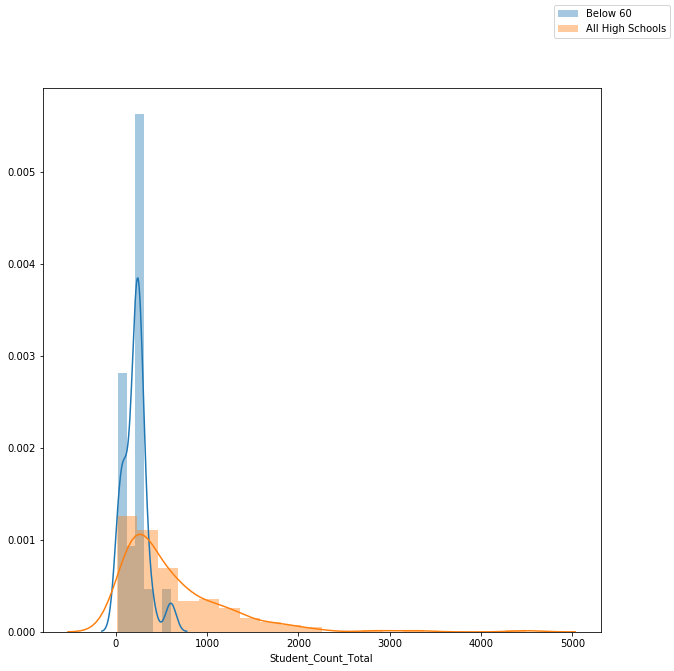

In [19]:
fig, ax = plt.subplots( figsize=(10,10))
sns.distplot(below_60['Student_Count_Total'], ax=ax, label='Below 60')
sns.distplot(sy_1819_hs['Student_Count_Total'], ax=ax, label='All High Schools')

fig.legend()

Only schools with student counts below 600 students have graduation rates below 60.  As shown in the histogram below, there are 12 schools with low graduation rates with a student count around 250.

In [1]:
sns.histplot(below_60['Student_Count_Total'],ax=ax, label='Below 60')


NameError: name 'sns' is not defined

# Independent Features to Explore

In [21]:
sy_1819_hs.head()

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

## Student Population Features

    
- Student_Count_Total
- Student_Count_Low_Income
- Student_Count_Special_Ed
- Student_Count_English_Learners
- Student_Count_Black
- Student_Count_Hispanic
- Student_Count_White
- Student_Count_Asian
- Student_Count_Native_American
- Student_Count_Other_Ethnicity
- Student_Count_Asian_Pacific_Islander
- Student_Count_Multi
- Student_Count_Hawaiian_Pacific_Islander
- Student_Count_Ethnicity_Not_Available

In [22]:
student_pop_feature_list = [
    "Student_Count_Total",
    "Student_Count_Low_Income",
    "Student_Count_Special_Ed",
    "Student_Count_English_Learners",
    "Student_Count_Black",
    "Student_Count_Hispanic",
    "Student_Count_White",
    "Student_Count_Asian",
    "Student_Count_Native_American",
    "Student_Count_Other_Ethnicity",
    "Student_Count_Asian_Pacific_Islander",
    "Student_Count_Multi",
    "Student_Count_Hawaiian_Pacific_Islander",
    "Student_Count_Ethnicity_Not_Available"]

### Student Count Total

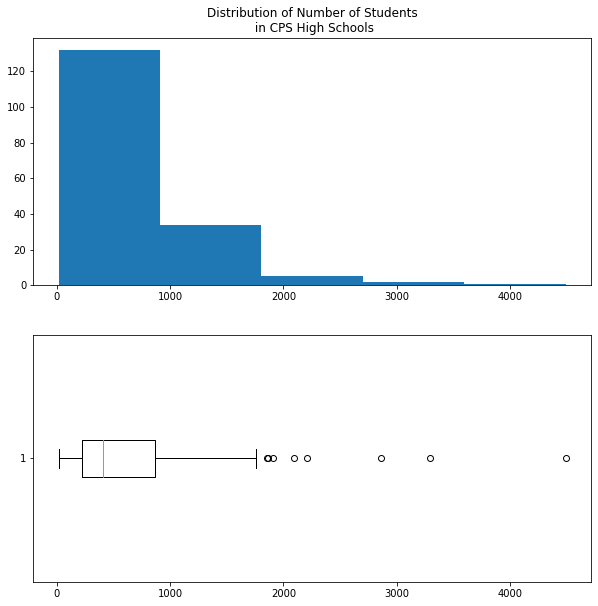

In [23]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
ax1.hist(sy_1819_hs['Student_Count_Total'], bins=5)
ax2.boxplot(sy_1819_hs['Student_Count_Total'], vert=False)
ax1.set_title('Distribution of Number of Students\n in CPS High Schools');

In [24]:
sy_1819_hs.sort_values(by='Student_Count_Total')\
        [['Short_Name_sp', 'Student_Count_Total', 'Network']].sort_values('Student_Count_Total', ascending=False).head()


,Short_Name_sp,Student_Count_Total,Network
625,LANE TECH HS,4494,Network 14
643,TAFT HS,3294,Network 14
636,CURIE HS,2859,Network 15
202,YOUNG HS,2205,ISP
427,LINCOLN PARK HS,2094,ISP


In [25]:
sy_1819_hs[sy_1819_hs['Student_Count_Total'] > 2000]\
        [['Short_Name_sp', 'Student_Count_Total', 'Network']].sort_values('Student_Count_Total', ascending=False)


,Short_Name_sp,Student_Count_Total,Network
625,LANE TECH HS,4494,Network 14
643,TAFT HS,3294,Network 14
636,CURIE HS,2859,Network 15
202,YOUNG HS,2205,ISP
427,LINCOLN PARK HS,2094,ISP


In [26]:
sy_1819_hs[['Student_Count_Total', 'Graduation_Rate_School']].corr()

,Student_Count_Total,Graduation_Rate_School
Student_Count_Total,1.000000,0.427355
Graduation_Rate_School,0.427355,1.000000


In [27]:
hs_1819_main_nws[['Student_Count_Total', 'Graduation_Rate_School']].corr()

,Student_Count_Total,Graduation_Rate_School
Student_Count_Total,1.000000,0.466951
Graduation_Rate_School,0.466951,1.000000


In [28]:
sy_1819_hs[sy_1819_hs['Graduation_Rate_School']==0]

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

Along with the schools with a graduation rate of 0, there are also 38 schools with N/A grad rates.  

In [29]:
sy_1819_hs[sy_1819_hs['Graduation_Rate_School'].isna()][['Short_Name_sp', 'Graduation_Rate_School', 'Network']].shape

(38, 3)

Of those 38, 25 are Option Schools.

In [30]:
sy_1819_hs[sy_1819_hs['Graduation_Rate_School'].isna()]['Network'].value_counts()

Options       25
Charter        7
ISP            5
Network 14     1
Name: Network, dtype: int64

That leaves only 7 Options Network schools with graduation rates. 

In [31]:
sy_1819_hs['Network'].value_counts()['Options']

32

THe drop_no_grad_rate function removes the 40 schools from the dataframe.

In [32]:
sy_1819_hs = drop_no_grad_rate(sy_1819_hs)


0 Graduation Rate
2 schools
261    PATHWAYS - AVONDALE HS
343     NORTHSIDE LEARNING HS
Name: Short_Name_sp, dtype: object
##########
NA Graduation Rates
38 schools
All 0/NA Graduation Rate Schools Dropped


In [33]:
sy_1819_hs.head()

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

In [34]:
len(sy_1819_hs.School_ID.unique())

134

Below is a list of school ids included in the 2017-18 school year, but not in the 2018-19 school year.

In [35]:
# schools_not_in_1819 = []
# for id_ in sy_1718.merged_df['School_ID']:
#      if id_ not in list(sy_1819_hs['School_ID']):
#             schools_not_in_1819.append(id_)
# schools_not_in_1819

### Student Count Total

Each school record includes the total number of students who attend a school.

There were 357,779 students enrolled in CPS in 2018-19. 

In [36]:
sy_1819['Student_Count_Total'].sum()

357779

The high school dataset after cleaning has 98,661 students in the 2018-19 school year.

In [37]:
sy_1819_hs['Student_Count_Total'].sum()

98661

In [38]:
sy_1819_hs['Student_Count_Total'].describe()

count     134.000000
mean      736.276119
std       657.342650
min        21.000000
25%       296.750000
50%       558.500000
75%       994.250000
max      4494.000000
Name: Student_Count_Total, dtype: float64

Text(0, 0.5, 'Mean # of Students per Network')

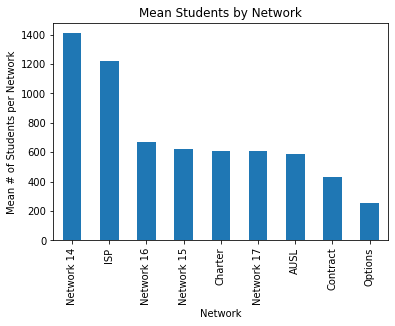

In [39]:
student_count_by_network = sy_1819_hs.groupby("Network").mean()['Student_Count_Total'].sort_values(ascending=False)

fig, ax = plt.subplots()

student_count_by_network.plot(kind='bar', ax = ax)
ax.set_title('Mean Students by Network')
ax.set_ylabel('Mean # of Students per Network')

Text(0, 0.5, 'Mean # of Students per Network')

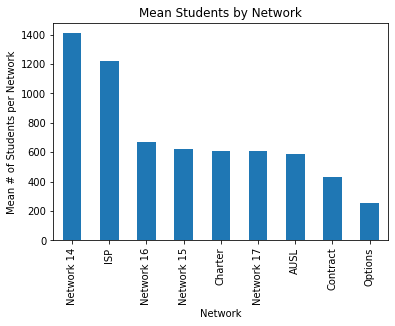

In [40]:
student_count_by_network = sy_1819_hs.groupby("Network").mean()['Student_Count_Total'].sort_values(ascending=False)

fig, ax = plt.subplots()

student_count_by_network.plot(kind='bar', ax = ax)
ax.set_title('Mean Students by Network')
ax.set_ylabel('Mean # of Students per Network')

The plots show a heavy right skew to the school total student counts.  There are 5 large high schools with student counts over 2000 students.

In [41]:
sy_1819_hs[sy_1819_hs['Student_Count_Total'] > 2000]\
        [['Short_Name_sp', 'Student_Count_Total']].sort_values('Student_Count_Total', ascending=False)


,Short_Name_sp,Student_Count_Total
625,LANE TECH HS,4494
643,TAFT HS,3294
636,CURIE HS,2859
202,YOUNG HS,2205
427,LINCOLN PARK HS,2094


The school with the largest student body is Lane Tech High School, with 4494 students.

In [42]:
sy_1819_hs[sy_1819_hs['Student_Count_Total'] == 
                  sy_1819_hs['Student_Count_Total'].max()][['Short_Name_sp', 'Student_Count_Total']]

,Short_Name_sp,Student_Count_Total
625,LANE TECH HS,4494


The median number of students is 404.

In [43]:
sy_1819_hs['Student_Count_Total'].median()

558.5

Text(0.5, 1.0, 'Student Count in Bins of 100\n: Largest bin is 200-300')

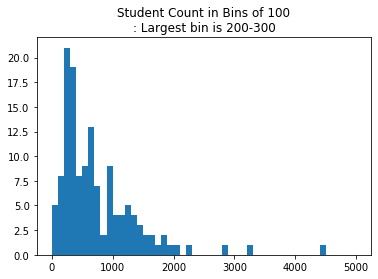

In [44]:
# Plot of counts in 2018-19 school year split into bins of 100 students
bins_100 = np.linspace(0,5000, 51)

fig, ax = plt.subplots()
ax.hist(sy_1819_hs['Student_Count_Total'], bins_100)
ax.set_title('Student Count in Bins of 100\n: Largest bin is 200-300')

Interquartile Range: 219-853
The interquartile range for High School students count in the 2018-19 School Year is 219-853 students.

In [45]:
q75, q25 = np.percentile(sy_1819_hs['Student_Count_Total'], [75 ,25])
print(q25, q75)

296.75 994.25


Schools in the lowest quartile of student counts 

In [46]:

low_quartile = sy_1819_hs[sy_1819_hs['Student_Count_Total'] < q25]

low_quartile.shape

(34, 277)

Text(0.5, 1.0, 'Options Networks have a High Proportion of Low Population Schools')

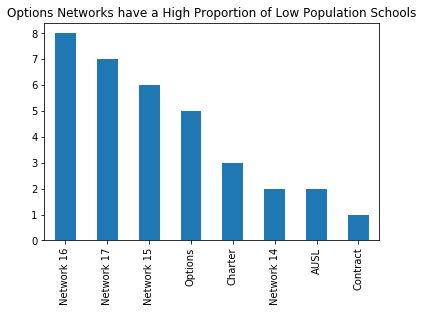

In [47]:
fig, ax = plt.subplots()
low_quartile['Network'].value_counts().plot(kind='bar', ax = ax)
ax.set_title('Options Networks have a High Proportion of Low Population Schools')

In [48]:
q90, q10 = np.percentile(sy_1819_hs['Student_Count_Total'], [90 ,10])
print(q90, q10)

1432.9 204.2


In [49]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']<=q10].shape

(14, 277)

There are two high schools with 0 students on record. These will need to be dropped when modeling occurs.

In [50]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']==0]

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

There are 5 schools with less than 50 students.  As of yet, these will not be dropped, but may be dropped due to other filters.

In [51]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']<50].shape

(2, 277)

**Modeling Note** All schools with no students will be dropped before modeling begins.

## Low Income Students

There is a high correlation between Count of Low Income Students and Graduation rate.

In [52]:
sy_1819_hs[['Student_Count_Low_Income', 'Graduation_Rate_School']].corr()

,Student_Count_Low_Income,Graduation_Rate_School
Student_Count_Low_Income,1.000000,0.407281
Graduation_Rate_School,0.407281,1.000000


In [53]:
sy_1819_hs.head()

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

In [54]:
sy_1819_hs[['perc_low_income', 'Graduation_Rate_School']].corr()

,perc_low_income,Graduation_Rate_School
perc_low_income,1.000000,-0.324445
Graduation_Rate_School,-0.324445,1.000000


### There is a strong positive correlation between total number of students and total number of low income students

Text(0.5, 1.0, 'Positive Correlation Between Total Students and Low Income Students')

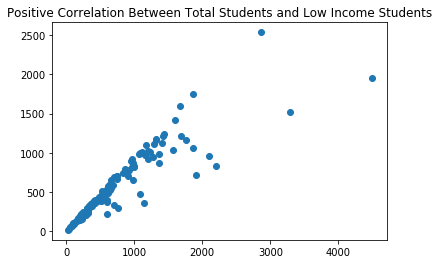

In [55]:
fig, ax = plt.subplots()

x = sy_1819_hs['Student_Count_Total']
y = sy_1819_hs['Student_Count_Low_Income']

ax.scatter(x, y )
ax.set_title("Positive Correlation Between Total Students and Low Income Students")

Text(0.5, 1.0, 'There are over 80 Schools\n with over 90% Low Income Students')

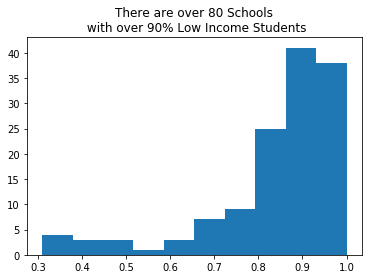

In [56]:
fig, ax = plt.subplots()

ax.hist(sy_1819_hs['perc_low_income'])
ax.set_title('There are over 80 Schools\n with over 90% Low Income Students')

Text(0.5, 1.0, 'Positive Correlation Between Total Students and Low Income Students')

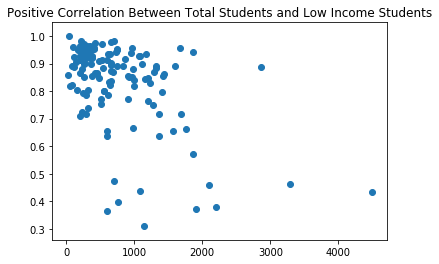

In [57]:
fig, ax = plt.subplots()

x = sy_1819_hs['Student_Count_Total']
y = sy_1819_hs['perc_low_income']

ax.scatter(x, y )
ax.set_title("Positive Correlation Between Total Students and Low Income Students")


In [58]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']<50]['Network']

5     Network 15
23    Network 16
Name: Network, dtype: object

In [59]:
sy_1819_hs[sy_1819_hs['Student_Count_Total']<100]['Network']

5      Network 15
23     Network 16
60     Network 15
175    Network 15
352    Network 16
Name: Network, dtype: object

# Special Ed

In [60]:
sy_1819_hs[['Student_Count_Special_Ed', 'Graduation_Rate_School']].corr()

,Student_Count_Special_Ed,Graduation_Rate_School
Student_Count_Special_Ed,1.00000,0.20983
Graduation_Rate_School,0.20983,1.00000


## Categorical Features

Feature list:
- Dress Code
- Networks


### Dress Code

Is there a significant difference in graduation rates in schools with and without dress codes?

In [61]:
dress_code_hs = sy_1819_hs[sy_1819_hs['Dress_Code']==True]
no_dress_code_hs = sy_1819_hs[sy_1819_hs['Dress_Code']==False]


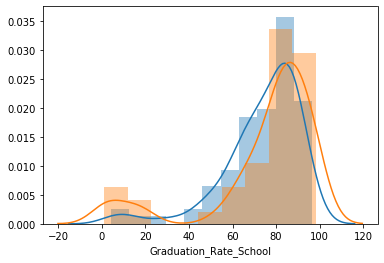

In [62]:
fig, ax = plt.subplots()
sns.distplot(dress_code_hs['Graduation_Rate_School'], ax=ax, norm_hist=True)
sns.distplot(no_dress_code_hs['Graduation_Rate_School'], ax=ax, norm_hist=True)

In [14]:
ttest_ind(dress_code_hs['Graduation_Rate_School'], no_dress_code_hs['Graduation_Rate_School'])

NameError: name 'dress_code_hs' is not defined

Ttest does not show significant difference.

### Networks

Is there a difference in graduation rates across the main networks?

In [38]:
main_nws = ['Network 14', 'Network 15', 'Network 16', 'Network 17']

In [39]:
sy_1819_hs.groupby('Network')

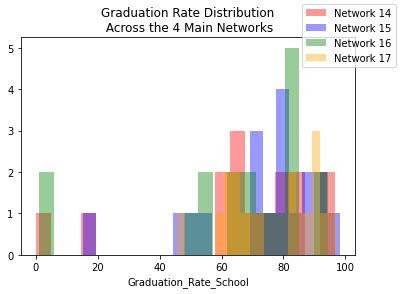

In [43]:
fig, ax = plt.subplots()

colors = ['r', 'b', 'g', 'orange']
for nw, color in zip(main_nws, colors):
    nw_gr = sy_1819_hs.groupby('Network').get_group(nw)['Graduation_Rate_School']
    sns.distplot(nw_gr, ax=ax, kde=False, color=color, label=nw, hist=True, bins=20)

ax.set_title('Graduation Rate Distribution\n Across the 4 Main Networks')
fig.legend()

Network 17 does not have any graduation rates below the 20% rate

#### ANOVA Test

In [37]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

hs_lm = ols('Graduation_Rate_School ~ C(Network)', data = sy_1819_hs).fit()

table = sm.stats.anova_lm(hs_lm, typ=2)

print(table)

                  sum_sq     df         F        PR(>F)
C(Network)  29498.922591    8.0  11.50346  4.066342e-12
Residual    39747.459965  124.0       NaN           NaN


ANOVA test for the Networks rejects the null hypothesis.  There is a difference in grad rates between the main networks.

### Network NA's


In [ ]:
sy_1819_hs['Network'].isna().sum()

In [ ]:
sy_1819_hs[sy_1819_hs['Network'].isna()]

## Number of students per network

In [ ]:
sy_1819_hs.groupby('Network').mean()['Student_Count_Total']

In [ ]:
fig, ax = plt.subplots()

y = sy_1819_hs.groupby('Network').mean()['Student_Count_Total'].sort_values().values
x = sy_1819_hs.groupby('Network').mean()['Student_Count_Total'].sort_values().index

ax.bar(x,y)
ax.set_xticklabels(x, rotation=45)
ax.set_title('Average Number of Students per School');

The Options network has significantly less number of average students.  

In [ ]:
sy_1819_hs.groupby('Network').sum()['Student_Count_Total']

# School Offerings

# Next Steps:

Investigate Low Income Student Counts

Investigate exactly what the two Contract Schools are.

Look at whether the graduation rates below 20% or 40% can be considered outliers.

In [ ]:
sy_1819_hs.head()